Setup, helpers, load data

In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from pathlib import Path
pd.set_option("display.max_columns", 200)

ROOT   = Path("..").resolve()
DATA   = ROOT/"data"
FIGS   = ROOT/"reports/figures"
TABLES = ROOT/"reports/tables"
FIGS.mkdir(parents=True, exist_ok=True)
TABLES.mkdir(parents=True, exist_ok=True)

def savefig(fig, name, subdir=""):
    p = FIGS/(subdir.strip("/")) if subdir else FIGS
    p.mkdir(parents=True, exist_ok=True)
    fig.savefig(p/f"{name}.png", dpi=300, bbox_inches="tight")
    print("Saved figure:", p/f"{name}.png")

def savetab(df, name, index=False):
    path = TABLES/f"{name}.csv"
    df.to_csv(path, index=index)
    print("Saved table:", path)

def read_data(path: Path):
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        first = f.readline()
    skip = 1 if first.lower().startswith("data derived") else 0
    return pd.read_csv(path, low_memory=False, skiprows=skip)

train = read_data(DATA/"training_loan_data.csv")
test  = read_data(DATA/"testing_loan_data.csv")
target_col = next((c for c in train.columns if c.strip().lower()=="bad_flag"), None)
assert target_col, "Target 'bad_flag' not found"

print("Train:", train.shape, "| Test:", test.shape, "| Target:", target_col)
train.head()


Train: (199121, 23) | Test: (102505, 23) | Target: bad_flag


,id,member_id,loan_amnt,term,int_rate,emp_length,home_ownership,annual_inc,desc,purpose,percent_bc_gt_75,bc_util,dti,inq_last_6mths,mths_since_recent_inq,revol_util,total_bc_limit,mths_since_last_major_derog,tot_hi_cred_lim,tot_cur_bal,application_approved_flag,internal_score,bad_flag
0,10000001,11983056.0,7550,36 months,16.24%,3 years,RENT,28000.0,NaN,debt_consolidation,100.0,96.0,8.40,0.0,17.0,72%,4000.0,NaN,3828.953801,5759.0,1,99,0.0
1,10000002,12002921.0,27050,36 months,10.99%,10+ years,OWN,55000.0,Borrower added on 12/31/13 > Combining high ...,debt_consolidation,25.0,53.9,22.87,0.0,8.0,61.20%,35700.0,NaN,34359.940730,114834.0,1,353,0.0
2,10000003,11983096.0,12000,36 months,10.99%,4 years,RENT,60000.0,Borrower added on 12/31/13 > I would like to...,debt_consolidation,0.0,15.9,4.62,1.0,3.0,24%,18100.0,NaN,16416.617760,7137.0,1,157,0.0
3,10000004,12003142.0,28000,36 months,7.62%,5 years,MORTGAGE,325000.0,NaN,debt_consolidation,16.7,67.1,18.55,1.0,3.0,54.60%,42200.0,NaN,38014.149760,799592.0,1,365,0.0
4,10000005,11993233.0,12000,36 months,13.53%,10+ years,RENT,40000.0,NaN,debt_consolidation,33.3,79.6,16.94,0.0,17.0,68.80%,7000.0,53.0,6471.462236,13605.0,1,157,0.0


Data quality + visuals

Saved table: /Users/manikmalhotra/jpm_quant_project/reports/tables/dtypes.csv
Saved table: /Users/manikmalhotra/jpm_quant_project/reports/tables/missingness.csv
Saved figure: /Users/manikmalhotra/jpm_quant_project/reports/figures/missingness_top30.png
Saved figure: /Users/manikmalhotra/jpm_quant_project/reports/figures/target_distribution.png


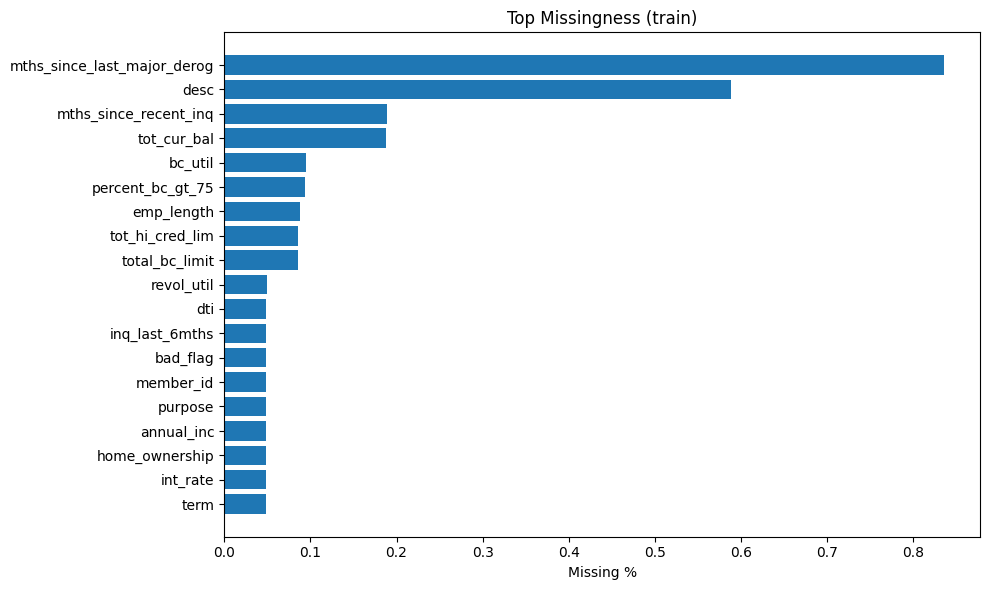

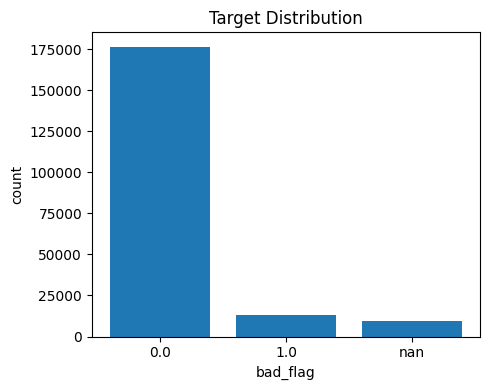

In [2]:
# dtypes
dtypes = train.dtypes.astype(str).reset_index().rename(columns={"index":"column",0:"dtype"})
savetab(dtypes, "dtypes")

# missingness
missing = train.isna().sum().sort_values(ascending=False).reset_index()
missing.columns = ["column","missing_count"]
missing["missing_pct"] = (missing["missing_count"]/len(train)).round(4)
savetab(missing, "missingness")

# figure: top missingness
top_miss = missing[missing.missing_count>0].head(30)
fig, ax = plt.subplots(figsize=(10,6))
ax.barh(top_miss["column"][::-1], top_miss["missing_pct"][::-1])
ax.set_xlabel("Missing %"); ax.set_title("Top Missingness (train)")
plt.tight_layout(); savefig(fig, "missingness_top30")

# figure: target distribution
fig, ax = plt.subplots(figsize=(5,4))
vc = train[target_col].value_counts(dropna=False).sort_index()
ax.bar(vc.index.astype(str), vc.values)
ax.set_title("Target Distribution"); ax.set_xlabel("bad_flag"); ax.set_ylabel("count")
plt.tight_layout(); savefig(fig, "target_distribution")
plt.show()


In [ ]:
Cleaning and Type Harmonization

In [3]:
work = train.copy()

def pct_to_float(s: pd.Series) -> pd.Series:
    return s.astype(str).str.replace('%','', regex=False).replace('nan', np.nan).astype(float)

for col in ["int_rate","revol_util"]:
    if col in work.columns and work[col].dtype == object:
        work[col] = pct_to_float(work[col])

num_cols = work.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = work.select_dtypes(include=["object"]).columns.tolist()
print("Numeric:", len(num_cols), "| Categorical:", len(cat_cols))
work.head(3)


Numeric: 18 | Categorical: 5


,id,member_id,loan_amnt,term,int_rate,emp_length,home_ownership,annual_inc,desc,purpose,percent_bc_gt_75,bc_util,dti,inq_last_6mths,mths_since_recent_inq,revol_util,total_bc_limit,mths_since_last_major_derog,tot_hi_cred_lim,tot_cur_bal,application_approved_flag,internal_score,bad_flag
0,10000001,11983056.0,7550,36 months,16.24,3 years,RENT,28000.0,NaN,debt_consolidation,100.0,96.0,8.40,0.0,17.0,72.0,4000.0,NaN,3828.953801,5759.0,1,99,0.0
1,10000002,12002921.0,27050,36 months,10.99,10+ years,OWN,55000.0,Borrower added on 12/31/13 > Combining high ...,debt_consolidation,25.0,53.9,22.87,0.0,8.0,61.2,35700.0,NaN,34359.940730,114834.0,1,353,0.0
2,10000003,11983096.0,12000,36 months,10.99,4 years,RENT,60000.0,Borrower added on 12/31/13 > I would like to...,debt_consolidation,0.0,15.9,4.62,1.0,3.0,24.0,18100.0,NaN,16416.617760,7137.0,1,157,0.0


In [ ]:
Univariate visuals

Saved figure: /Users/manikmalhotra/jpm_quant_project/reports/figures/univariate/numeric/hist_id.png
Saved figure: /Users/manikmalhotra/jpm_quant_project/reports/figures/univariate/numeric/hist_member_id.png
Saved figure: /Users/manikmalhotra/jpm_quant_project/reports/figures/univariate/numeric/hist_loan_amnt.png
Saved figure: /Users/manikmalhotra/jpm_quant_project/reports/figures/univariate/numeric/hist_int_rate.png
Saved figure: /Users/manikmalhotra/jpm_quant_project/reports/figures/univariate/numeric/hist_annual_inc.png
Saved figure: /Users/manikmalhotra/jpm_quant_project/reports/figures/univariate/numeric/hist_percent_bc_gt_75.png
Saved figure: /Users/manikmalhotra/jpm_quant_project/reports/figures/univariate/numeric/hist_bc_util.png
Saved figure: /Users/manikmalhotra/jpm_quant_project/reports/figures/univariate/numeric/hist_dti.png
Saved figure: /Users/manikmalhotra/jpm_quant_project/reports/figures/univariate/numeric/hist_inq_last_6mths.png
Saved figure: /Users/manikmalhotra/jpm_q

/var/folders/lr/y7z13ss51gv174jyk23f2jn00000gn/T/ipykernel_10283/159124670.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(vc.index.astype(str), rotation=45, ha="right")


Saved figure: /Users/manikmalhotra/jpm_quant_project/reports/figures/univariate/categorical/cat_counts_term.png


/var/folders/lr/y7z13ss51gv174jyk23f2jn00000gn/T/ipykernel_10283/159124670.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(vc.index.astype(str), rotation=45, ha="right")


Saved figure: /Users/manikmalhotra/jpm_quant_project/reports/figures/univariate/categorical/cat_counts_emp_length.png


/var/folders/lr/y7z13ss51gv174jyk23f2jn00000gn/T/ipykernel_10283/159124670.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(8,4))
/var/folders/lr/y7z13ss51gv174jyk23f2jn00000gn/T/ipykernel_10283/159124670.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(vc.index.astype(str), rotation=45, ha="right")


Saved figure: /Users/manikmalhotra/jpm_quant_project/reports/figures/univariate/categorical/cat_counts_home_ownership.png


/var/folders/lr/y7z13ss51gv174jyk23f2jn00000gn/T/ipykernel_10283/159124670.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(vc.index.astype(str), rotation=45, ha="right")


Saved figure: /Users/manikmalhotra/jpm_quant_project/reports/figures/univariate/categorical/cat_counts_desc.png


/var/folders/lr/y7z13ss51gv174jyk23f2jn00000gn/T/ipykernel_10283/159124670.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(vc.index.astype(str), rotation=45, ha="right")


Saved figure: /Users/manikmalhotra/jpm_quant_project/reports/figures/univariate/categorical/cat_counts_purpose.png


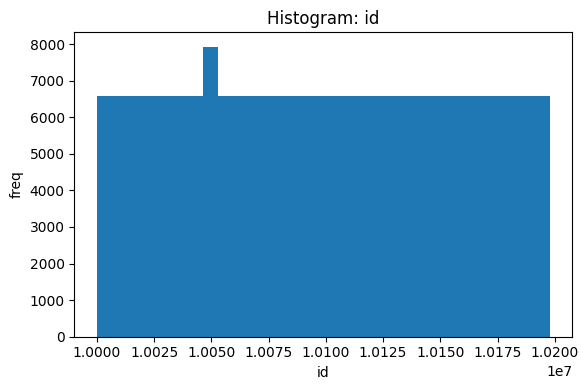

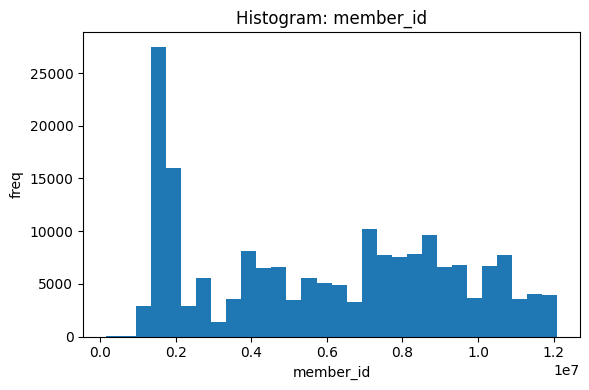

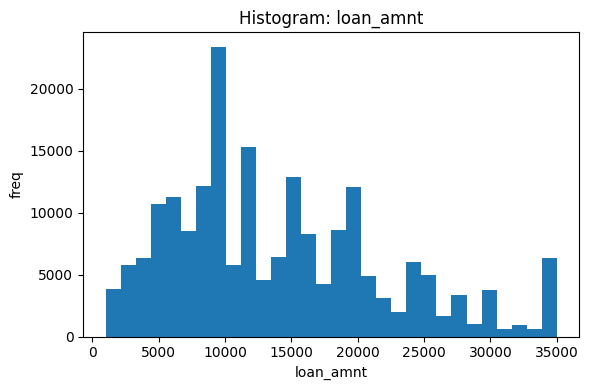

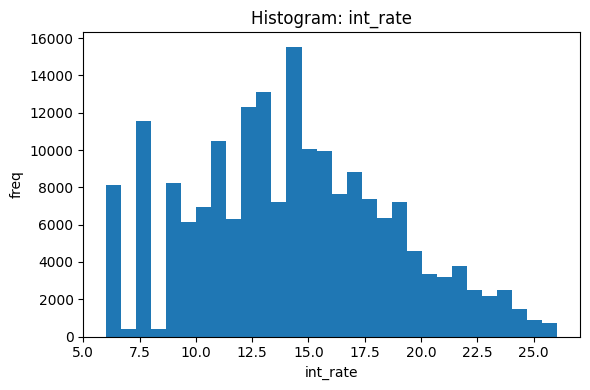

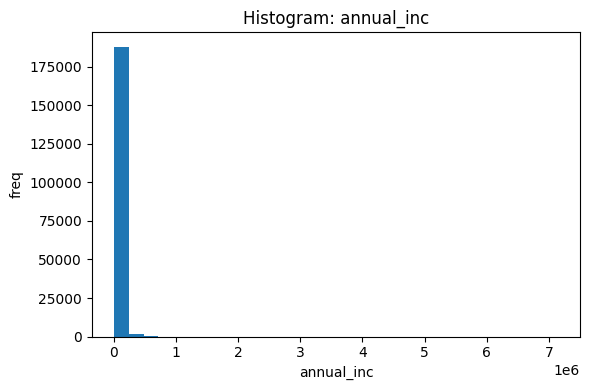

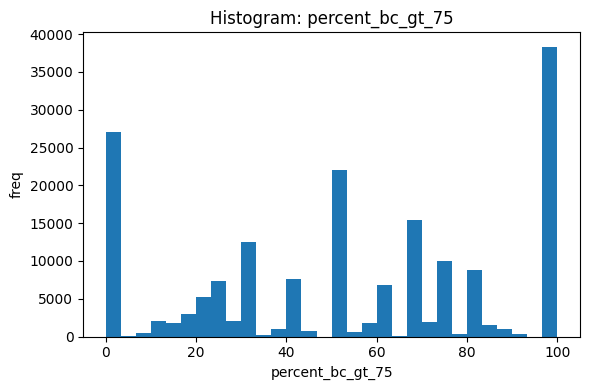

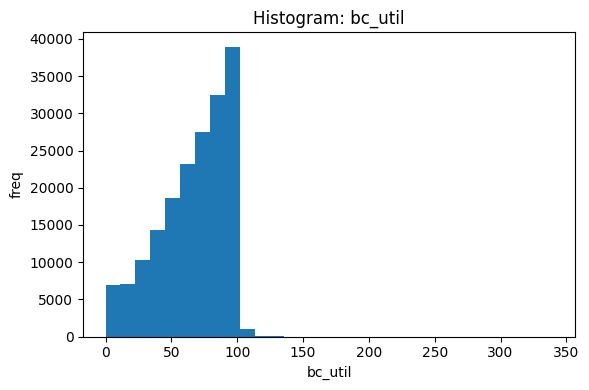

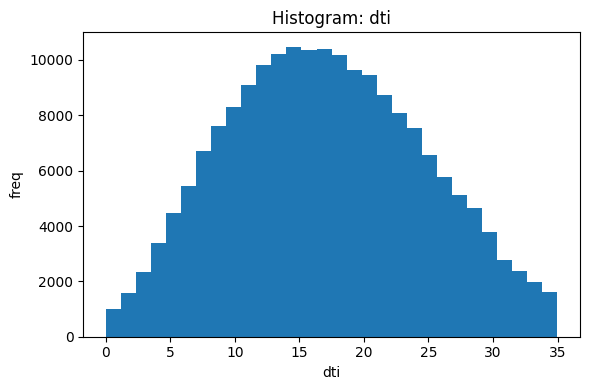

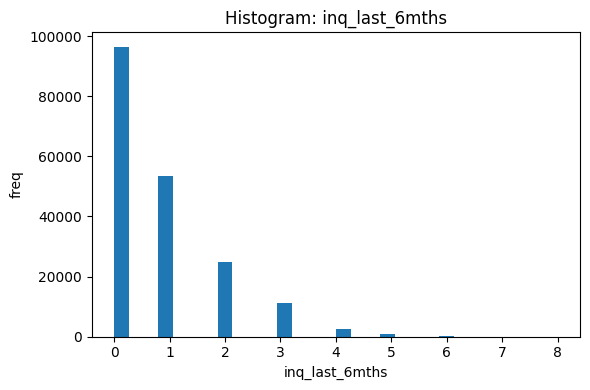

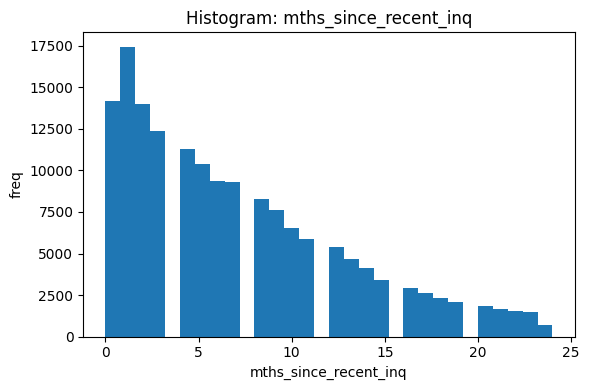

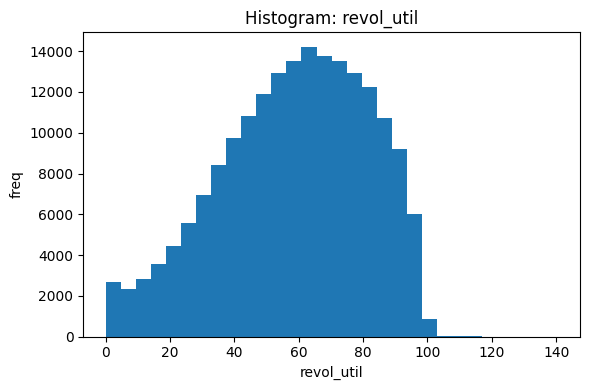

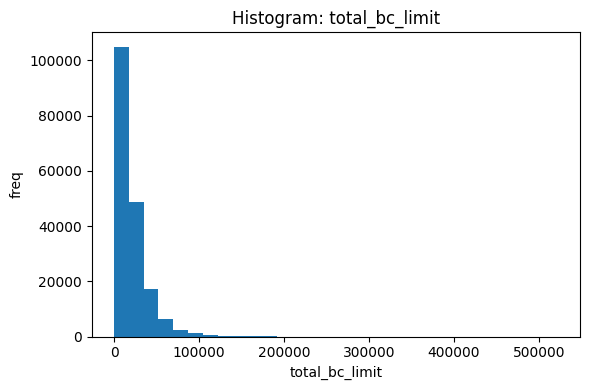

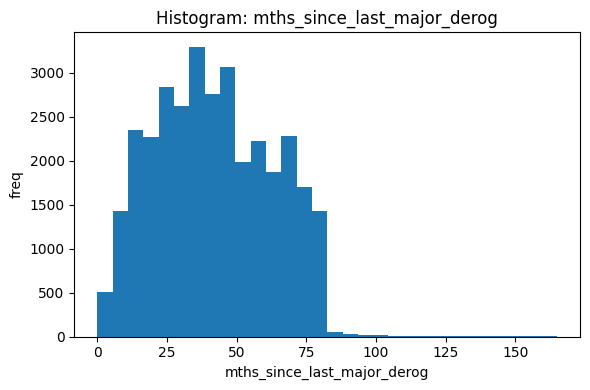

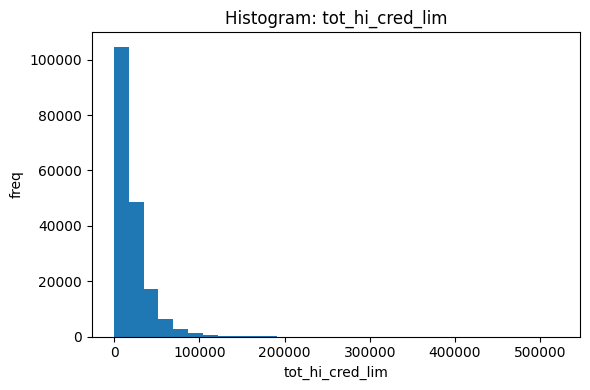

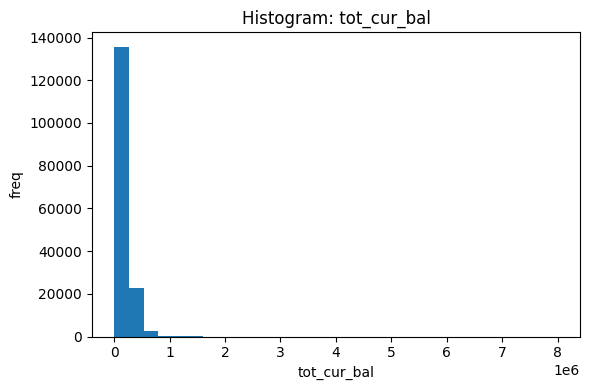

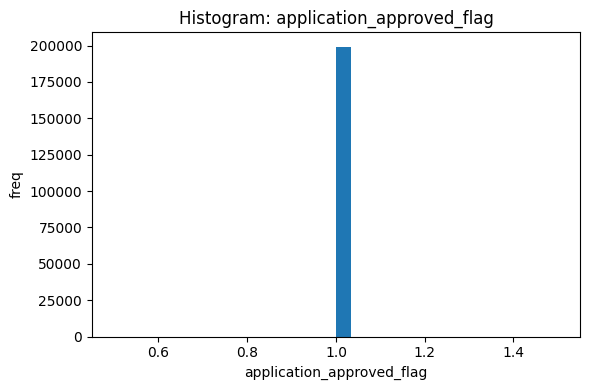

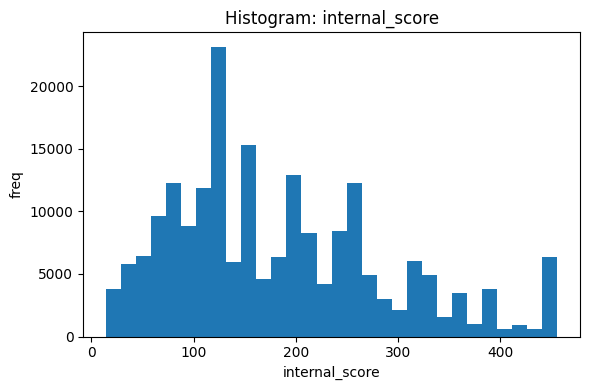

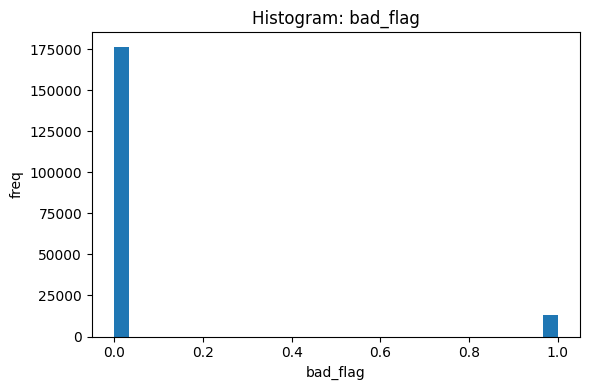

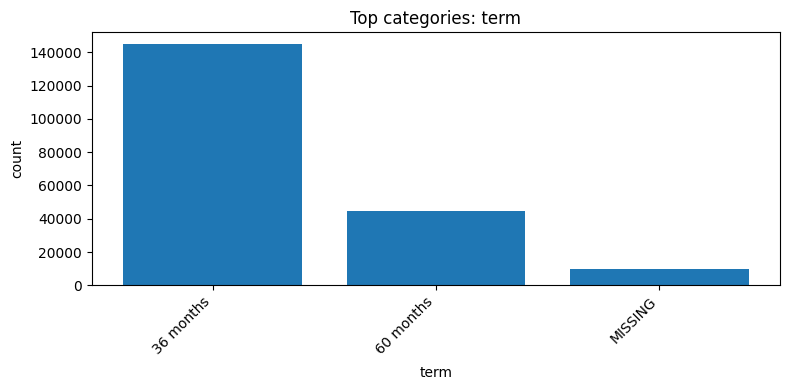

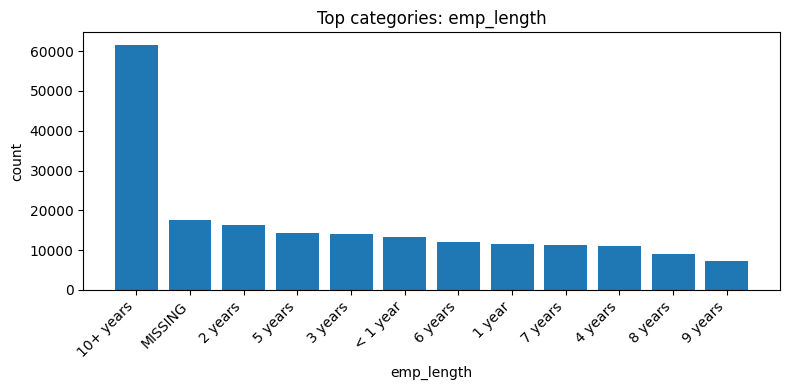

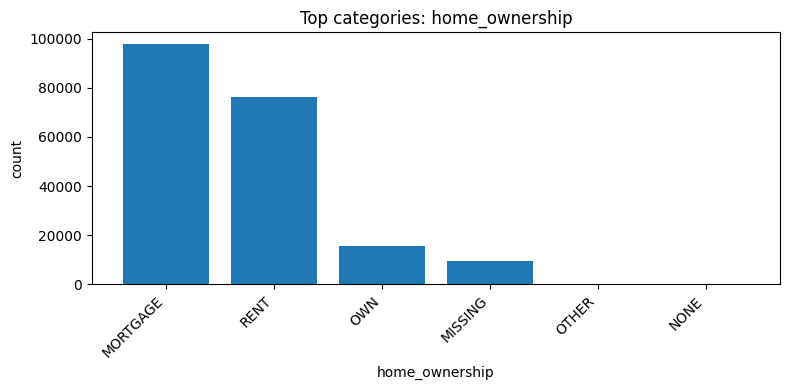

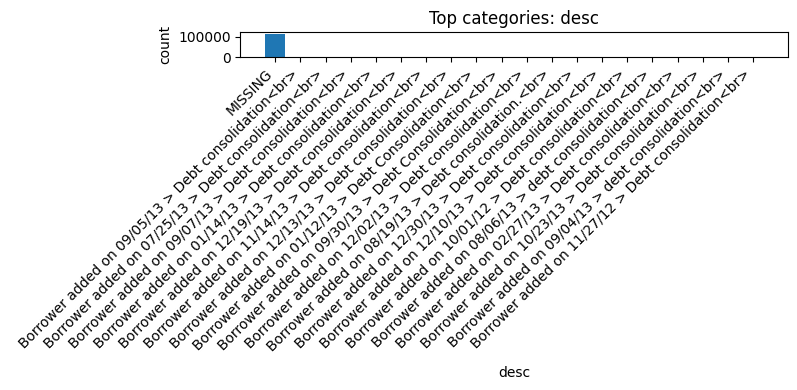

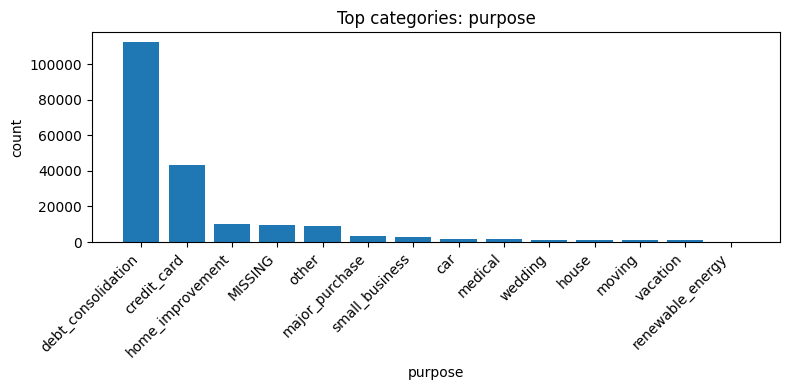

In [4]:
# numeric histograms (cap to 20 columns to avoid spam)
for col in num_cols[:20]:
    fig, ax = plt.subplots(figsize=(6,4))
    ax.hist(work[col].dropna().values, bins=30)
    ax.set_title(f"Histogram: {col}"); ax.set_xlabel(col); ax.set_ylabel("freq")
    plt.tight_layout(); savefig(fig, f"hist_{col}", subdir="univariate/numeric")

# categorical top counts (cap to 15 columns)
for col in cat_cols[:15]:
    fig, ax = plt.subplots(figsize=(8,4))
    vc = work[col].fillna("MISSING").value_counts().head(20)
    ax.bar(vc.index.astype(str), vc.values)
    ax.set_title(f"Top categories: {col}"); ax.set_xlabel(col); ax.set_ylabel("count")
    ax.set_xticklabels(vc.index.astype(str), rotation=45, ha="right")
    plt.tight_layout(); savefig(fig, f"cat_counts_{col}", subdir="univariate/categorical")
